# Imports

In [500]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

# Load the Image

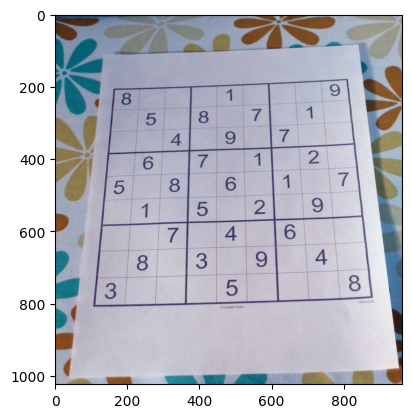

In [501]:
# req = urllib.request.urlopen('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSXWgbXAGTp-igspDP1qDo3aFJeE4vd_2u3Og&usqp=CAU')
req = urllib.request.urlopen('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg')
# req = urllib.request.urlopen('https://jump.dev/JuMP.jl/stable/assets/partial_sudoku.png')
# req = urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg')
# req = urllib.request.urlopen('https://cdn.britannica.com/42/97142-131-E3E24AA5/sudoku-puzzle-games.jpg')
# req = urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg')

arr = np.asarray(bytearray(req.read()), dtype=np.uint8) #transform image to array
img = cv2.imdecode(arr, -1) # 'Load it as it is'
# img = cv2.imread('/home/youssef/nagysudoku2.jpg')
plt.imshow(img, cmap="gray")

# Convert to Grayscale

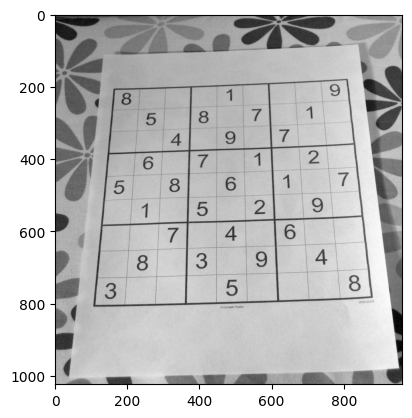

In [502]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap="gray") 

# Remove Noise using a 3x3 Gaussian Filter

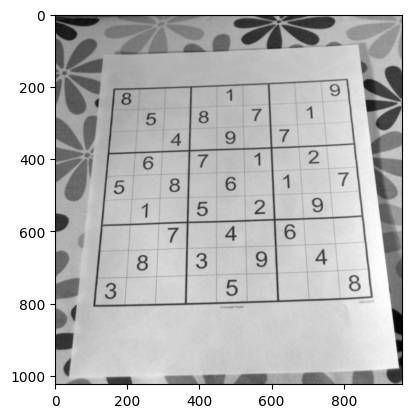

In [503]:
blurred = cv2.GaussianBlur(gray_image, (3, 3), cv2.BORDER_DEFAULT)
plt.imshow(blurred, cmap="gray")

# Adaptive Thresholding

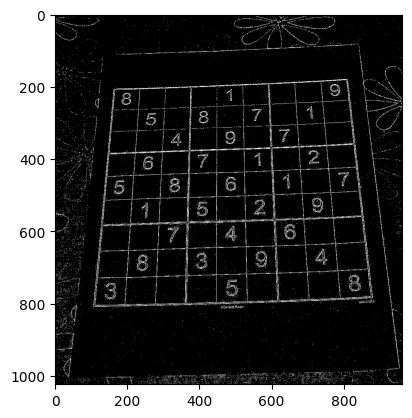

In [504]:
img_gray_threshed = cv2.adaptiveThreshold(src=gray_image,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=3,
    C=5
)
plt.imshow(img_gray_threshed, cmap="gray")

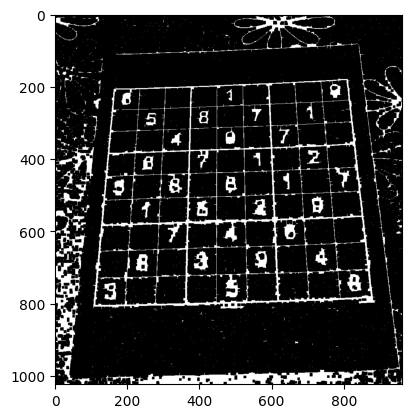

In [505]:
closed_grid = np.zeros_like(img_gray_threshed, dtype = np.uint8)
closed_grid = cv2.morphologyEx(img_gray_threshed, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
plt.imshow(closed_grid, cmap="gray")

# Get the largest object in the image using Cotours
## *It is assumed that the sudoku frame is the largest object in the image*

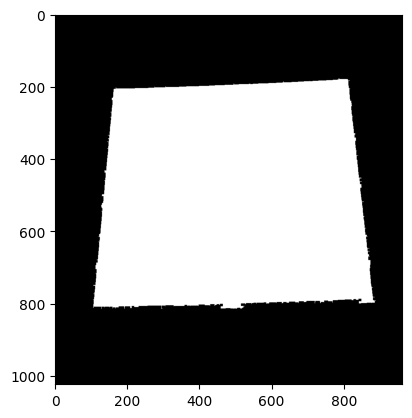

In [506]:

max = -1
x = -1
contours, _ = cv2.findContours(closed_grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
selected_contours = []
sudoku_square = np.zeros(img_gray_threshed.shape, np.uint8)
for i in range(len(contours)):
  area = cv2.contourArea(contours[i])
  if area > max:
     max = area
     x = i   

selected_contours.append(contours[x])
cv2.fillPoly(sudoku_square, pts=selected_contours, color= (255,255,255))
plt.imshow(sudoku_square, cmap="gray")

# Extract Edges using Canny

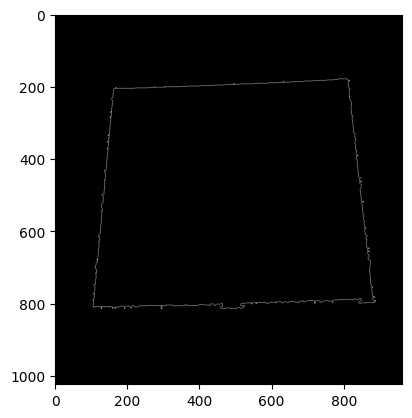

In [507]:
canny_img = cv2.Canny(sudoku_square, 50, 150)
plt.imshow(canny_img, cmap="gray")

# Remove Connected Components

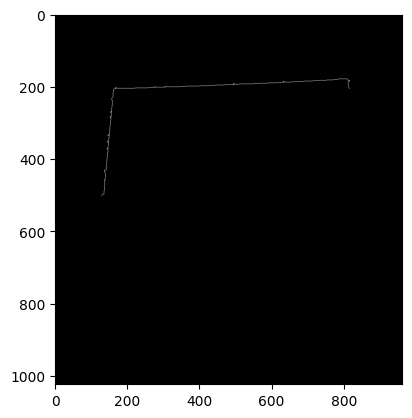

In [508]:
analysis = cv2.connectedComponentsWithStats(canny_img, 
                                            4, 
                                            cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 

output = np.zeros(gray_image.shape, dtype="uint8") 
  
for i in range(1, totalLabels): 
    # Area of the component 
    area = values[i, cv2.CC_STAT_AREA]  
      
    if (area > 400): 
        componentMask = (label_ids == i).astype("uint8") * 255
        output = cv2.bitwise_or(output, componentMask) 

plt.imshow(output, cmap="gray")

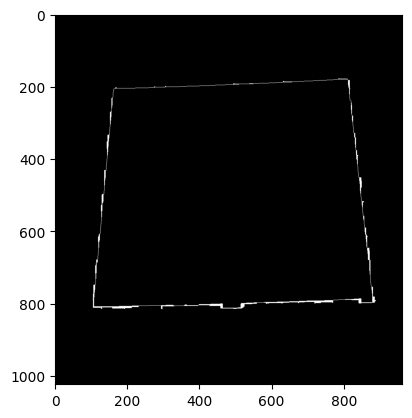

In [516]:
closed_grid = np.zeros_like(img_gray_threshed, dtype = np.uint8)
closed_grid = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25)))
plt.imshow(closed_grid, cmap="gray")

newimg = cv2.Canny(closed_grid, 50, 150)

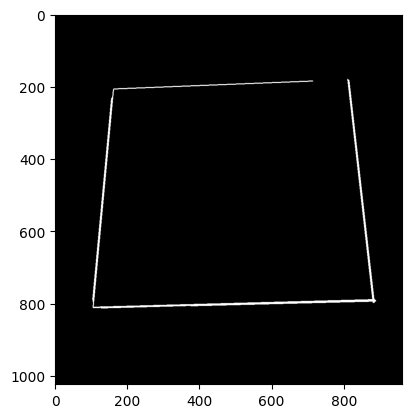

In [517]:
## Hough
minLineLength = min(img_gray_threshed.shape[0],img_gray_threshed.shape[1])/2
hough_linesy = cv2.HoughLinesP(
    image=closed_grid,
    rho=1,  # Distance resolution of the accumulator in pixels.
    theta=0.00115,  # Angle resolution of the accumulator in radians.
    threshold=150,  # Voting threshold for accumulator.
    lines=None,
    minLineLength=minLineLength,  #  Line segments shorter than that are rejected.
    maxLineGap=150 # Maximum allowed gap between points on the same line to link them.
)
for x0, y0, x1, y1 in hough_linesy[:,0]:
    cv2.line(img_gray_threshed, (x0, y0), (x1, y1), (255,0,0), 2, cv2.LINE_AA)
tmp_imgy = np.zeros_like(img_gray_threshed, dtype = np.uint8)
for x1, y1, x2, y2 in hough_linesy[:,0]: cv2.line(tmp_imgy,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(tmp_imgy, cmap='gray')

# Get the corners using Harris

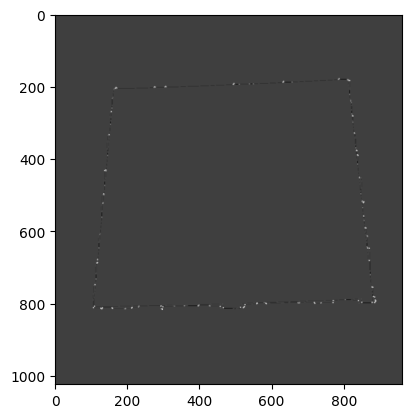

In [518]:
# blurred = cv2.GaussianBlur(tmp_imgy, (3, 3), cv2.BORDER_DEFAULT)

dest = cv2.cornerHarris(closed_grid, 2, 3, 0.05) 
  
# Results are marked through the dilated corners 
dest = cv2.dilate(dest, None) 
  
# Reverting back to the original image, 
# with optimal threshold value 

plt.imshow(dest, cmap="gray")

# Apply a Gaussian Filter, get the absolute values, then Threshhold to only get the corner points

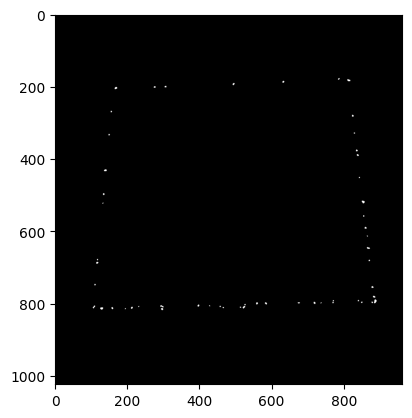

In [519]:
Gaussian_box = cv2.GaussianBlur(dest,(7,7), 0)
#plt.imshow(Gaussian_box, cmap='gray');
Gaussian_box = np.abs(Gaussian_box)
#plt.imshow(Gaussian_box, cmap='gray');

# for i in range(Gaussian_box.shape[0]):
#     for j in range(Gaussian_box.shape[1]):
#         if Gaussian_box[i][j] > 0:
#             print(Gaussian_box[i][j])
ret, thresh1 = cv2.threshold(Gaussian_box, 0.035, 255, cv2.THRESH_BINARY) 

plt.imshow(thresh1, cmap='gray')

# Get the coordinates of the Corners

In [525]:
#x = np.zeros((1000))
#y = np.zeros((1000))
coords = []
#for i in range(1000):
#    x[i] = 99999
#    y[i] = 99999



# print(thresh1.shape)
for i in range(thresh1.shape[0]):
    for j in range(thresh1.shape[1]):
        if thresh1[i][j] == 255:
            coords.append((i, j))
            
maxCoord = (-1, -1)
maxSum = -1
print(coords[i][0][0])
for i in range(len(coords)):
    sum = coords[i][0][0]


#minimum x that has minimum y

# print(x)
# print(y)

# corners = cv2.goodFeaturesToTrack(thresh1, 27, 0.01, 10) 
# corners = np.int0(corners) 

# maxX = np.max(x)
# maxY = np.max(y)
# minX = np.min(x)
# minY = np.min(y)

# x1, y1 = minX, minY
# x2, y2 = maxX, minY
# x3, y3 = minX, maxY
# x4, y4 = maxX, maxY

# c1 = [x1, y1]
# c2 = [x2, y2]
# c3 = [x3, y3]
# c4 = [x4, y4]

# print(c1)
# print(c2)
# print(c3)
# print(c4)

print(corners)

264.5
[[[769 793]]

 [[841 452]]

 [[456 809]]

 [[525 804]]

 [[838 793]]

 [[466 812]]

 [[514 811]]

 [[117 681]]

 [[853 560]]

 [[829 329]]

 [[869 648]]

 [[106 813]]

 [[783 180]]

 [[676 798]]

 [[110 750]]

 [[149 335]]

 [[155 271]]

 [[193 816]]

 [[230 810]]

 [[428 808]]

 [[734 800]]

 [[847 798]]

 [[869 681]]

 [[864 615]]

 [[131 524]]

 [[718 801]]

 [[883 799]]]


# Perspective Transform

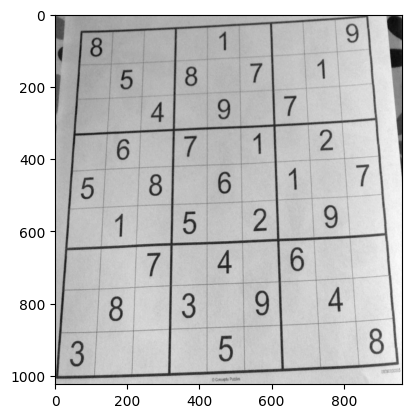

In [521]:


# y, x = img_gray_threshed.shape
# src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
# dst_coords = np.float32([[c1[::-1], c2[::-1], c4[::-1], c3[::-1]]])
# img_gray_threshed_warped = cv2.warpPerspective(
#     src=img_gray_threshed,
#     M=cv2.getPerspectiveTransform(dst_coords, src_coords),
#     dsize=img_gray_threshed.shape[::-1]
# )
# plt.imshow(img_gray_threshed_warped, cmap="gray");
# pts1 = np.float32([c1[::-1], c2[::-1],
#                        c3[::-1], c4[::-1]])
# # pts2 = np.float32([[0, 0], [400, 0],
#                       # [0, 640], [400, 640]])
     
# # Apply Perspective Transform Algorithm
# matrix = cv2.getPerspectiveTransform(pts1, src_coords)
# result = cv2.warpPerspective(img_gray_threshed, matrix, img_gray_threshed.shape)

# plt.imshow(result, cmap='gray')



input_points = np.float32([c1, c2, c3, c4])
width = img.shape[1]
height = img.shape[0]

converted_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
# print(matrix)
img_output = cv2.warpPerspective(gray_image, matrix, (width, height))
plt.imshow(img_output, cmap="gray")





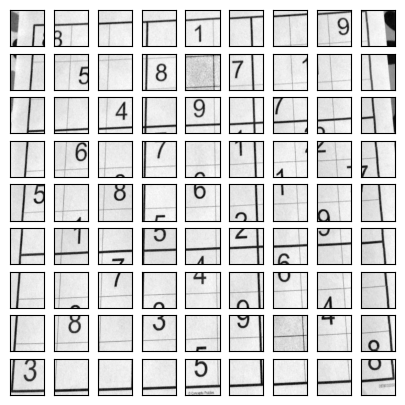

In [515]:
M = img_output.shape[0] // 9
N = img_output.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = img_output[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)